In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.metrics import mean_squared_error

In [ ]:

data = pd.read_csv("data.csv")
# attribute = ['Hz','Phasa-A (kV)', 'Phasa-B (kV)', 'Phasa-C (kV)']
attribute = data.columns


In [ ]:
def make_set(sindex, data_len, corr_thesh):
  is_par = [-1 for i in range(0, len(attribute))]
  cor = data[sindex:data_len].corr(method ='pearson')
  g1 = []
  g2 = [i for i in range(0, len(attribute))]

  bf = [0 for i in range(0, len(attribute))]
  pos = [-1 for i in range(0, len(attribute))]

  flag = True
  while flag:
    flag = False
    cand = []
    for i in g2:
      if(bf[i] > corr_thesh):
        continue
      flag = True
      attr = attribute[i]
      gain = 0
      for j in g2:
        if cor[attribute[j]][attr] > bf[j]:
          gain += cor[attribute[j]][attr] > bf[j]
      cand.append([i, gain])
    if flag == False:
      break;
    max_gain = 0
    max_pos = -1
    for i in cand:
      if i[1] >= max_gain:
        max_pos = i[0]
        max_gain = i[1]
    g1.append(max_pos)
    g2.remove(max_pos)
    for i in g2:
      if cor[attribute[i]][attribute[max_pos]] >= bf[i]:
        bf[i] = cor[attribute[i]][attribute[max_pos]]
        pos[i] = max_pos

      
  l = [[] for i in range(0, len(attribute))]
  for i in g1:
    l[i].append(i)
  for i in g2:
    l[pos[i]].append(i)


  l.remove([])

  sets = [i for i in l if i != []]
  for i in g2:
    is_par[i] = pos[i]
  return sets, is_par

In [ ]:
def get_base_model(start_index, data_len, base_data, lag, ep):
  print(ep)
  X = [np.zeros(1 * lag)]
  t = [np.zeros(1)]
  for i in range(start_index, start_index + data_len - lag):
    buf = []
    tar = []
    tar.append(base_data[i + lag])
    for j in range(i, i + lag):
        buf.append(base_data[j])
    X = np.concatenate((X, [np.array(buf)]))
    t = np.concatenate((t, [np.array(tar)]))
  svr_base = SVR(kernel='rbf', C=10000, epsilon=ep)
  res = svr_base.fit(X, np.ravel(t))
  return res

def get_non_base_model(start_index, data_len, attr_data, base_data, lag, ep):
  print(ep)
  num_features = 3
  X = [np.zeros(1 * num_features)]
  t = [np.zeros(1)]
  for i in range(start_index, start_index + data_len):
    buf = []
    tar = []
    tar.append(attr_data[i])
    buf = [base_data[i]]
    for j in range(1, num_features):
      buf.append(buf[-1]*base_data[i])
    X = np.concatenate((X, [np.array(buf)]))
    t = np.concatenate((t, [np.array(tar)]))
  svr_attr = SVR(kernel='rbf', C=10000, epsilon=ep)
  res = svr_attr.fit(X, np.ravel(t))
  return res

In [ ]:
def grid(l, b, c):
  lag = l
  threshold = 0.012
  buff = b
  corr_thesh = c
  pred = data.copy()
  sets, par = make_set(0, buff, corr_thesh)
  print(sets)
  model = []
  for i in range(0, len(attribute)):
    if par[i] == -1:
      model.append(get_base_model(0, buff, data[attribute[i]], lag, abs(threshold * data[attribute[i]][0]) / 2))
    else:
      model.append(get_non_base_model(0, buff, data[attribute[i]], data[attribute[par[i]]], lag, abs(threshold * data[attribute[i]][0]) / 2))

  num_features = 3
  
  retrain = [0 for i in range(0, len(attribute))]
  send = [0 for i in range(0, len(attribute))]
  send_till = [0 for i in range(0, len(attribute))]
  for cur_pos in range(lag + 1, len(data) - buff):
    cur_pred = [-1 for i in range(0, len(attribute))]
    for i in range(0, len(attribute)):
      if par[i] == -1:
        buf = []
        for j in range(cur_pos - lag, cur_pos):
          buf.append(pred[attribute[i]][j])
        cur_pred[i] = model[i].predict([buf])[0]
        if abs(cur_pred[i] - data[attribute[i]][cur_pos]) > abs(threshold * data[attribute[i]][0]):
          retrain[i] += 1
          send[i] += cur_pos + buff - max(cur_pos, send_till[i])
          send_till[i] = cur_pos + buff
          model[i] = get_base_model(cur_pos, buff, data[attribute[i]], lag, abs(threshold * data[attribute[i]][0]) / 2)
          cur_pred[i] = data[attribute[i]][cur_pos]
          for k in range(cur_pos - lag - 1, cur_pos):
            pred[attribute[i]][k] = data[attribute[i]][k]

    for i in range(0, len(attribute)):
      if par[i] != -1:  
        buf = [cur_pred[par[i]]]
        for j in range(1, num_features):
          buf.append(buf[-1] * cur_pred[par[i]])
        cur_pred[i] = model[i].predict([buf])[0]
        if abs(cur_pred[i] - data[attribute[i]][cur_pos]) > abs(threshold * data[attribute[i]][0]):
          retrain[i] += 1
          send[i] += cur_pos + buff - max(cur_pos, send_till[i])
          send_till[i] = cur_pos + buff
          if data[attribute[i]][cur_pos:cur_pos + buff].corr(data[attribute[par[i]]][cur_pos:cur_pos + buff]) > corr_thesh:
            model[i] = get_non_base_model(cur_pos, buff, data[attribute[i]], data[attribute[par[i]]], lag)
          else:
            par[i] = -1
            for j in range(0, len(attribute)):
              if par[j] == -1:
                if data[attribute[i]][cur_pos:cur_pos + buff].corr(data[attribute[j]][cur_pos:cur_pos + buff]) > corr_thesh:
                  par[i] = j
            if par[i] == -1:
              model[i] = get_base_model(cur_pos, buff, data[attribute[i]], lag)
            else: 
              model[i] = get_non_base_model(cur_pos, buff, data[attribute[i]], data[attribute[par[i]]], lag)
      
    for i in range(0, len(attribute)):
      pred[attribute[i]][cur_pos] = cur_pred[i]
  return [pred, send, retrain]

In [ ]:
a = grid(5, 100, 0.85)

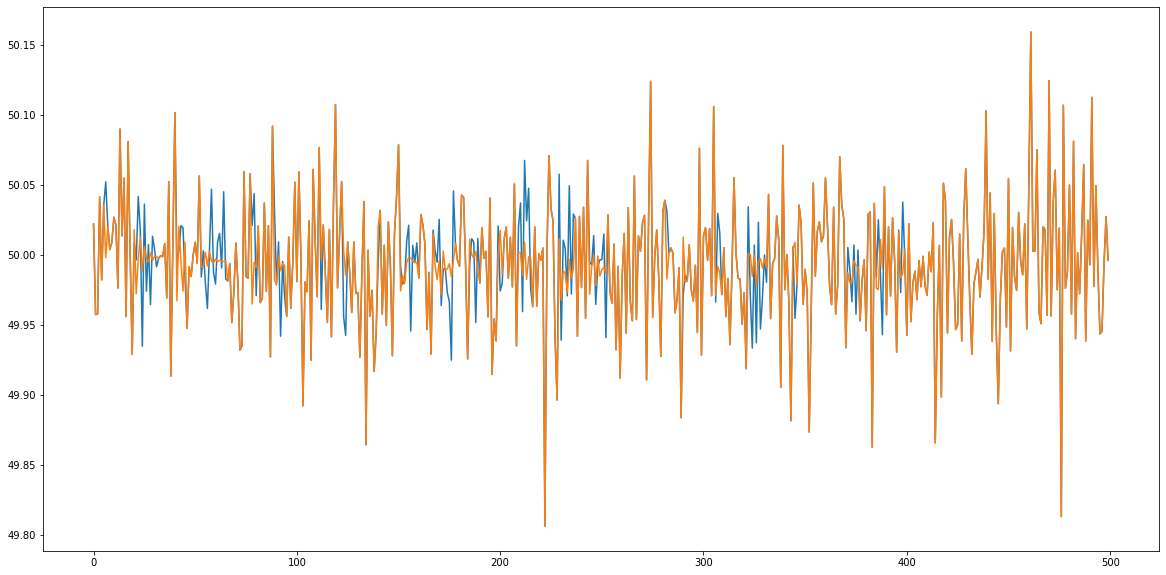

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(range(0, pred.shape[0]), data[attribute[0]], label = 'Original')
plt.plot(range(0, pred.shape[0]), pred[attribute[0]], label = 'Predicted')
plt.show()

In [ ]:
pred = a[0]